# **SEA 820 NLP Final Project: Detecting AI-Generated Text**

**Team Members**: Abhi Patel & Arnav Nigam

**Dataset**: https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text?resource=download

# **Project Overview**

- To build a classifier to detect whether a piece of text is human-written or AI-generated.

- We are going to explore classical machine learning models (Logistic Regression and Naive Bayes) using TF-IDF features.

- The goal is to establish a strong baseline for comparison with transformer models in Phase 2 of our project.

# **Phase 1: Data Exploration & Preprocessing:**

Do some data exploration and implement a baseline model to use with phase 2.


In [1]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## **Loading and exploring dataset**

Dataset is from `https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text?resource=download`.

Consists of over 400000 texts. Either human or AI generated, with a mapping of 0 as human generated and 1 as Ai generated.

In [ ]:
dataset = '/content/drive/MyDrive/NLP/AI_Human.csv'

df = pd.read_csv(dataset)
print("Dataset loaded successfully!")
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

# Preview first 5 rows
df.head()

Dataset loaded successfully!
Shape: (487235, 2)

Columns: ['text', 'generated']


,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


### **Basic information of our dataset:**

In [ ]:
print("Missing values per column:")
print(df.isnull().sum())

print("Dataset Info:")
df.info()

Missing values per column:
text         0
generated    0
dtype: int64
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487235 entries, 0 to 487234
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   text       487235 non-null  object 
 1   generated  487235 non-null  float64
dtypes: float64(1), object(1)
memory usage: 7.4+ MB


### **Class Distribution**

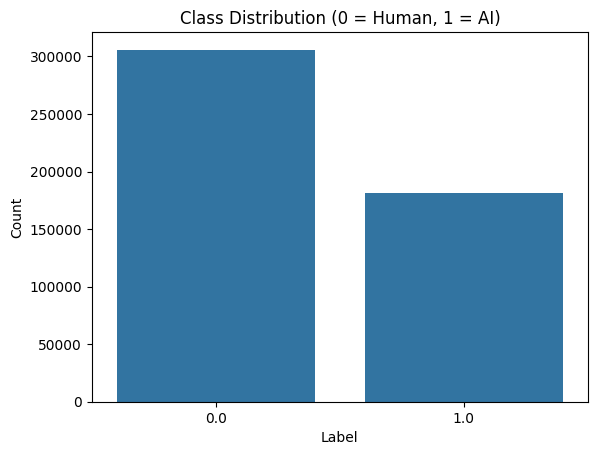

Class counts:
 generated
0.0    305797
1.0    181438
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=df, x='generated')
plt.title('Class Distribution (0 = Human, 1 = AI)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Optional: exact class counts
print("Class counts:\n", df['generated'].value_counts())

The graph above shows a clear imbalance between human generated and AI generated text, with majority of being human generated. A 65% of human generated may cause overfitting with both AI and human generated texts being tagged as human. However, let us see how our model will perform with this kind of imbalance.

### **Text Length Distribution**

Text length stats:
 count    487235.000000
mean        393.096214
std         168.593328
min           0.000000
25%         278.000000
50%         363.000000
75%         471.000000
max        1668.000000
Name: text_length, dtype: float64


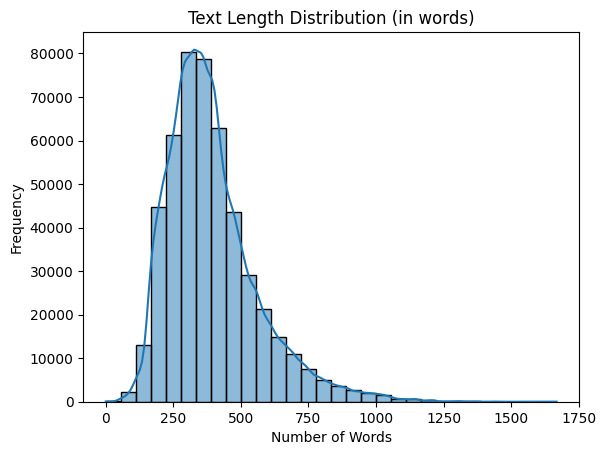

In [ ]:
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
print("Text length stats:\n", df['text_length'].describe())

# Histogram
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title('Text Length Distribution (in words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

The above shows us how the text distrivution is like:

- The distribution is right-skewed (positively skewed), with the majority of texts falling between 250 and 500 words.

- The peak seems to be around 350–400 words, which aligns closely with the median to be around 393.

- A few texts are very short (even 0 words), possibly due to empty or missed entries, which may require further cleaning as we proceed.

### **Data Preprocessing Pipeline:**

We will work with nltk to do our data preprocessing, we have used this earlier in our previous assignments giving us a quick headstart at this point. Additionally, we tried using spacy but due to the size of the dataset and spacy being heavy with we were running out of resources on google colab, therefore went ahead with nltk.

Not only that, but we wanted simplicity and speed over advanced linguistic parsing. NLTK's tools are sufficient for this phase.

The following steps were carried out for our preprocessing:

1. Lowercasing

2. Removing punctuation and digits

3. Removing stopwords

4. Lemmatization (using spaCy)

5. Tokenization

In [ ]:
import nltk
import string
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tqdm import tqdm

# Setup
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and t not in string.punctuation]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

tqdm.pandas()
df['processed_text'] = df['text'].astype(str).progress_apply(preprocess_text)



100%|██████████| 487235/487235 [27:22<00:00, 296.70it/s]


In [ ]:
# save preprcessed test fir future use
output_path = '/content/drive/MyDrive/NLP/preprocessed_dataset.csv'
df.to_csv(output_path, index=False)
print(f"Preprocessed dataset saved to: {output_path}")

Preprocessed dataset saved to: /content/drive/MyDrive/NLP/preprocessed_dataset.csv


# **Data exploration after processing**

After data preporcesing we went ahead and did some data cleaning to fill out the empty textbox.

- Missing processed_text values are filled with an empty string

- Rows with empty or whitespace-only processed_text are removed, This ensures that only meaningful text data is retained


In [28]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/NLP/preprocessed_dataset.csv')

# Fill missing values with empty string (if any)
df['processed_text'] = df['processed_text'].fillna('')

# Drop empty rows after trimming whitespace
df = df[df['processed_text'].str.strip() != '']

In [29]:
print("Dataset loaded successfully")
print("Cleaned Data Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

# Preview first 5 rows
df.head()

Dataset loaded successfully
Cleaned Data Shape: (487230, 4)

Columns: ['text', 'generated', 'text_length', 'processed_text']


,text,generated,text_length,processed_text
0,Cars. Cars have been around since they became ...,0.0,584,car car around since became famous 1900s henry...
1,Transportation is a large necessity in most co...,0.0,462,transportation large necessity country worldwi...
2,"""America's love affair with it's vehicles seem...",0.0,744,`` america 's love affair 's vehicle seems coo...
3,How often do you ride in a car? Do you drive a...,0.0,686,often ride car drive one motor vehicle work st...
4,Cars are a wonderful thing. They are perhaps o...,0.0,871,car wonderful thing perhaps one world greatest...


This cleaning step above ensures that all texts passed to the TF-IDF vectorizer and models are valid and meaningful.

### **Word Frequencies in both AI and Human generated text (Showing top 10)**

This helps to gives a glimpse of the top 10 word occurence between human and AI generated text.

In [30]:
from collections import Counter

word_freq = Counter()

for text in df['processed_text']:
    tokens = text.split()
    word_freq.update(tokens)

top_words = word_freq.most_common(10)

print("Top 10 Most Frequent Words (All):")
for word, freq in top_words:
    print(f"{word}: {freq}")


import matplotlib.pyplot as plt

# plotting
def plot_freq(counter, title):
    top_items = counter.most_common(10)
    words, freqs = zip(*top_items)
    plt.figure(figsize=(8,4))
    plt.bar(words, freqs)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

Top 10 Most Frequent Words (All):
student: 1565308
car: 1201736
people: 1171584
would: 1025164
's: 957259
school: 786572
n't: 760661
help: 643832
also: 643000
time: 627524


Top 10 Words (Human):
student: 1145169
car: 908254
people: 898740
would: 884305
n't: 689354
school: 614796
's: 575916
'': 547071
could: 459729
get: 459274


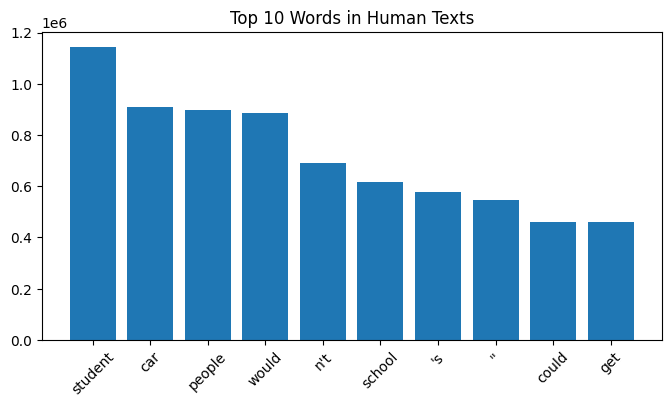

In [31]:
word_freq_human = Counter()

for text in df[df['generated'] == 0.0]['processed_text']:
    tokens = text.split()
    word_freq_human.update(tokens)

print("Top 10 Words (Human):")
for word, freq in word_freq_human.most_common(10):
    print(f"{word}: {freq}")

plot_freq(word_freq_human, "Top 10 Words in Human Texts")

Top 10 Words (AI):
student: 420139
's: 381343
car: 293482
people: 272844
also: 239022
help: 225166
electoral: 220153
college: 205285
like: 203048
state: 198130


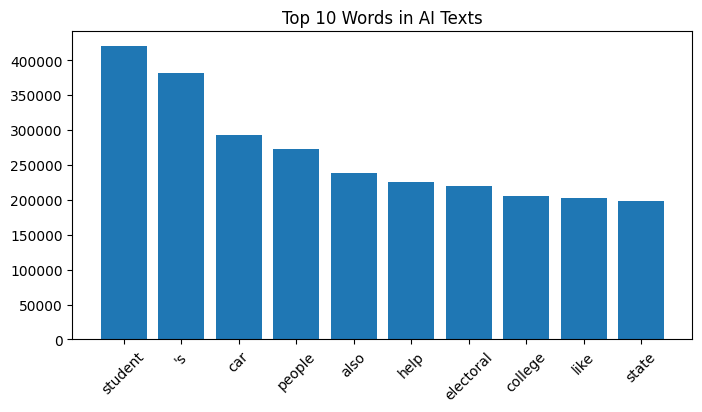

In [32]:
word_freq_ai = Counter()

for text in df[df['generated'] == 1.0]['processed_text']:
    tokens = text.split()
    word_freq_ai.update(tokens)

print("Top 10 Words (AI):")
for word, freq in word_freq_ai.most_common(10):
    print(f"{word}: {freq}")

plot_freq(word_freq_ai, "Top 10 Words in AI Texts")


# **Implementing Baseline Model:**

### **TF-IDF Feature Extraction**

To convert the cleaned text into numerical features suitable for machine learning, we used TF-IDF (Term Frequency–Inverse Document Frequency) vectorization. This method assigns weights to words (or n-grams) based on how important they are in a document relative to the entire corpus.

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Configure the vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=15000, #Limits the vocabulary to the 15,000 most informative terms based on frequency and TF-IDF scores, helping reduce dimensionality and overfitting.
    min_df=5,           #Ignores terms that appear in fewer than 5 documents, removing rare and potentially noisy word
    max_df=0.85,        #Ignores terms that appear in more than 85% of documents, eliminating overly common
    ngram_range=(1, 2), #Helps to capture both unigrams and bigrams
    sublinear_tf=True
)

X = tfidf_vectorizer.fit_transform(df['processed_text'])
y = df['generated']

print("TF-IDF shape:", X.shape)

TF-IDF shape: (487230, 15000)


The resulting output is a sparse matrix of shape (487230, 15000) — where each row corresponds to a document and each column to a term or n-gram feature.

### **Splitted the processed dataset to 80% being used in training and 20% used in test.**

In [34]:
from sklearn.model_selection import train_test_split

# Use X from new TF-IDF
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

With the above, we have fianlly chosen to use 2 models, naive bayes and logisitc regression in order to choose our baseline model. Alot will be needed to decide the final baseline model. Such as metrics and sets of exmaples to see how the model performs in real life

### **Baseline Model Option 1: Logistic Regression**

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
)

lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_lr, digits=4))

Logistic Regression Performance:
              precision    recall  f1-score   support

         0.0     0.9958    0.9967    0.9963     61159
         1.0     0.9945    0.9929    0.9937     36287

    accuracy                         0.9953     97446
   macro avg     0.9952    0.9948    0.9950     97446
weighted avg     0.9953    0.9953    0.9953     97446



From the above metrics, Logistic Regression performs exceptionally well across all metrics, with high precision and recall for both human and AI-generated texts. It has a very low false positive and false negative rate on our test set.

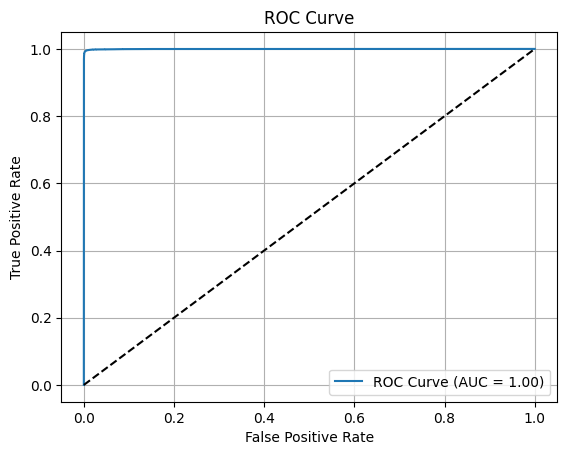

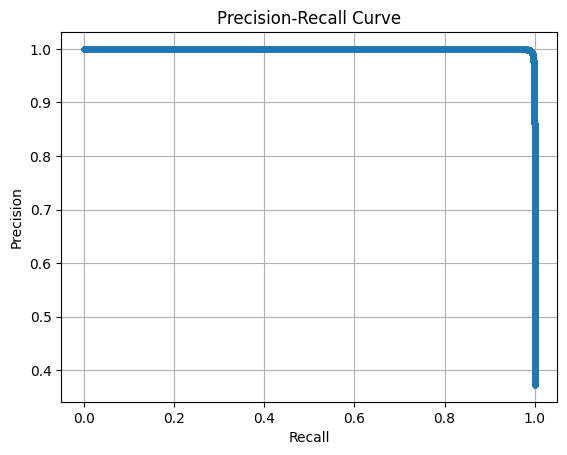

In [36]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc

y_scores = lr_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

In [37]:
# save model to drive for future use
import pickle

with open('/content/drive/MyDrive/NLP/lr_model_new.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

### **Baseline Model Option 2: Multinomial Naive Bayes**

In [38]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

print("Naive Bayes Performance:")
print(classification_report(y_test, y_pred_nb, digits=4))

Naive Bayes Performance:
              precision    recall  f1-score   support

         0.0     0.9707    0.9830    0.9768     61159
         1.0     0.9707    0.9500    0.9602     36287

    accuracy                         0.9707     97446
   macro avg     0.9707    0.9665    0.9685     97446
weighted avg     0.9707    0.9707    0.9706     97446



From the above metrics,  Naive Bayes performs slightly lower than Logistic Regression on this dataset. It achieves strong performance, but has a lower recall for AI-generated texts, indicating more false negatives (misclassifying AI as human).

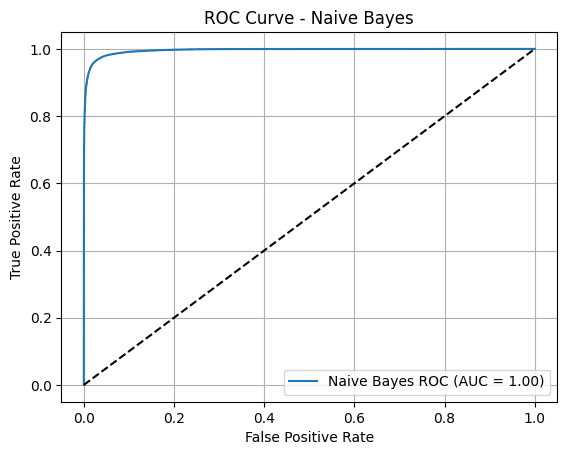

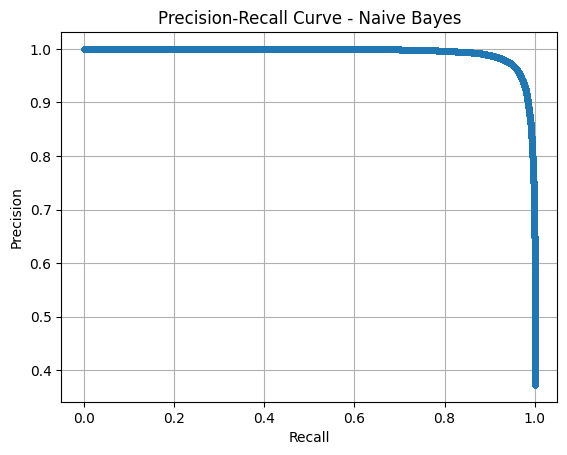

In [39]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for class 1
y_scores_nb = nb_model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_scores_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

plt.plot(fpr_nb, tpr_nb, label=f"Naive Bayes ROC (AUC = {roc_auc_nb:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Naive Bayes")
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision_nb, recall_nb, _ = precision_recall_curve(y_test, y_scores_nb)

plt.plot(recall_nb, precision_nb, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Naive Bayes")
plt.grid(True)
plt.show()


In [47]:
# save model to drive for future use
import pickle

with open('/content/drive/MyDrive/NLP/nb_model.pkl', 'wb') as f:
    pickle.dump(nb_model, f)

### **Confusion Matrix**

To help see the true positives and false positives

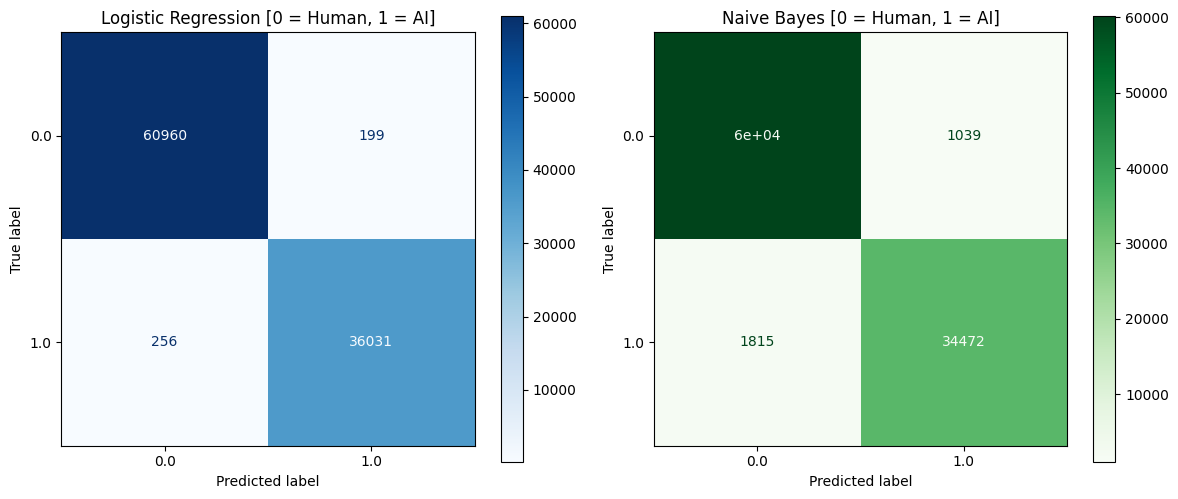

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, ax=ax[0], cmap='Blues')
ax[0].set_title("Logistic Regression [0 = Human, 1 = AI]")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb, ax=ax[1], cmap='Greens')
ax[1].set_title("Naive Bayes [0 = Human, 1 = AI]")

plt.tight_layout()
plt.show()

### **Model Exploration and choosing baseline model after training**

In [41]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('punkt_tab')

nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and punctuation
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in string.punctuation and t not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return ' '.join(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [42]:
import pandas as pd
import numpy as np

## **Sampling using the logistic regression model**

In [43]:
# Sample: Human-written texts
human_samples = [
    "The school times were the best, we had the opportunity to hang around, be lazy and don't do our assignments, I wish I was still in school.",
    "Our jobs are indeed becoming automated, just the other day I had the chance of building an automated agent using GPTs new feature and ordered myself a chicken rotisserie form Costco. It was such an unbelivable moment in office.",
    "A wise man once said, by losing a battle does not mean you lost a war, it just shows oyur time is not right and you have a few more chances to get this right. SO why not ocncentrate on our next steps and future, rather than concentrating on what has occured. I believe, it all happens for the good",
    "Driving while using your cell phone has become a very controversial issue currently. Millions of drivers have had mixed feelings and opinions on this subject. In result, people have taken opposing sides. Some believe driving with using your phone isn't such a dangerous task, while others strongly believe it is an action that should never be done by drivers. They argue that this is very unsafe and can distract the driver from paying attention to the road. I agree. I believe that drivers should not use their cellphones while driving.",
    "There are many differant reasons to limit car usage, the most well-known reason being that it will greatly reduce air pollution. Several places incuding Vauban Germany, Paris, Bogota Colombia, and the United States have proven this, especially Paris. Paris at one point in 2014, had to enforce a partial driving ban purely because of the hazzardous smog caused by air pollution. In doing so Paris relatively quickly cleared the majority of the smog, and realized how this can also help to reduce road congestion. The United States are another, larger example of how much limiting car use can help to reduce greenhouse gas emissions."
]


# Preprocess
human_df = pd.DataFrame({"text": human_samples})
human_df["processed_text"] = human_df["text"].apply(preprocess_text)

# Vectorize using trained TF-IDF
X_human = tfidf_vectorizer.transform(human_df["processed_text"])

# Predict
human_preds = lr_model.predict(X_human)
human_probs = lr_model.predict_proba(X_human)

# Display results
for i, (text, pred, prob) in enumerate(zip(human_samples, human_preds, human_probs)):
    label = "Human" if pred == 0 else "AI-Generated"
    confidence = max(prob)
    print(f"\n[Human Sample {i+1}]:\n{text}")
    print(f"Prediction: {label} (Confidence: {confidence:.4f})")


[Human Sample 1]:
The school times were the best, we had the opportunity to hang around, be lazy and don't do our assignments, I wish I was still in school.
Prediction: Human (Confidence: 0.7677)

[Human Sample 2]:
Our jobs are indeed becoming automated, just the other day I had the chance of building an automated agent using GPTs new feature and ordered myself a chicken rotisserie form Costco. It was such an unbelivable moment in office.
Prediction: AI-Generated (Confidence: 0.6872)

[Human Sample 3]:
A wise man once said, by losing a battle does not mean you lost a war, it just shows oyur time is not right and you have a few more chances to get this right. SO why not ocncentrate on our next steps and future, rather than concentrating on what has occured. I believe, it all happens for the good
Prediction: AI-Generated (Confidence: 0.6208)

[Human Sample 4]:
Driving while using your cell phone has become a very controversial issue currently. Millions of drivers have had mixed feelings

In [44]:
# Sample: AI-generated texts
ai_samples = [
    "The implications of artificial intelligence in healthcare are far-reaching, promising better diagnosis and treatment outcomes through machine learning.",
    "In the realm of astrophysics, black holes are defined not by their size, but by their gravitational pull, which even light cannot escape.",
    "Economic inflation is often a result of supply chain disruptions and increasing consumer demand, especially in post-crisis scenarios.",
    "Climate change continues to pose significant challenges, requiring coordinated global efforts to reduce carbon emissions and embrace renewable energy.",
    "The evolution of language models has opened new doors in natural language understanding, enabling more human-like interactions with AI."
]

# Preprocess
ai_df = pd.DataFrame({"text": ai_samples})
ai_df["processed_text"] = ai_df["text"].apply(preprocess_text)

# Transform
X_ai = tfidf_vectorizer.transform(ai_df["processed_text"])

# Predict
ai_preds = lr_model.predict(X_ai)
ai_probs = lr_model.predict_proba(X_ai)

# Display
for i, (text, pred, prob) in enumerate(zip(ai_samples, ai_preds, ai_probs)):
    label = "Human" if pred == 0 else "AI-Generated"
    confidence = np.max(prob)
    print(f"\n[AI Sample {i+1}]:\n{text}")
    print(f"Prediction: {label} (Confidence: {confidence:.4f})")



[AI Sample 1]:
The implications of artificial intelligence in healthcare are far-reaching, promising better diagnosis and treatment outcomes through machine learning.
Prediction: AI-Generated (Confidence: 0.9954)

[AI Sample 2]:
In the realm of astrophysics, black holes are defined not by their size, but by their gravitational pull, which even light cannot escape.
Prediction: AI-Generated (Confidence: 0.9510)

[AI Sample 3]:
Economic inflation is often a result of supply chain disruptions and increasing consumer demand, especially in post-crisis scenarios.
Prediction: AI-Generated (Confidence: 0.9953)

[AI Sample 4]:
Climate change continues to pose significant challenges, requiring coordinated global efforts to reduce carbon emissions and embrace renewable energy.
Prediction: AI-Generated (Confidence: 1.0000)

[AI Sample 5]:
The evolution of language models has opened new doors in natural language understanding, enabling more human-like interactions with AI.
Prediction: AI-Generated 

## **Sampling using the naive bayes model**

In [45]:
# Sample: Human-written texts
human_samples = [
    "The school times were the best, we had the opportunity to hang around, be lazy and don't do our assignments, I wish I was still in school.",
    "Our jobs are indeed becoming automated, just the other day I had the chance of building an automated agent using GPTs new feature and ordered myself a chicken rotisserie form Costco. It was such an unbelivable moment in office.",
    "A wise man once said, by losing a battle does not mean you lost a war, it just shows oyur time is not right and you have a few more chances to get this right. SO why not ocncentrate on our next steps and future, rather than concentrating on what has occured. I believe, it all happens for the good",
    "Driving while using your cell phone has become a very controversial issue currently. Millions of drivers have had mixed feelings and opinions on this subject. In result, people have taken opposing sides. Some believe driving with using your phone isn't such a dangerous task, while others strongly believe it is an action that should never be done by drivers. They argue that this is very unsafe and can distract the driver from paying attention to the road. I agree. I believe that drivers should not use their cellphones while driving.",
    "There are many differant reasons to limit car usage, the most well-known reason being that it will greatly reduce air pollution. Several places incuding Vauban Germany, Paris, Bogota Colombia, and the United States have proven this, especially Paris. Paris at one point in 2014, had to enforce a partial driving ban purely because of the hazzardous smog caused by air pollution. In doing so Paris relatively quickly cleared the majority of the smog, and realized how this can also help to reduce road congestion. The United States are another, larger example of how much limiting car use can help to reduce greenhouse gas emissions."
]

# Transform human samples using same TF-IDF vectorizer
X_human_nb = tfidf_vectorizer.transform(human_df["processed_text"])

# Predict
human_preds_nb = nb_model.predict(X_human_nb)
human_probs_nb = nb_model.predict_proba(X_human_nb)

# Display results
for i, (text, pred, prob) in enumerate(zip(human_samples, human_preds_nb, human_probs_nb)):
    label = "Human" if pred == 0 else "AI-Generated"
    confidence = max(prob)
    print(f"\n[Human Sample {i+1}]:\n{text}")
    print(f"Prediction: {label} (Confidence: {confidence:.4f})")


[Human Sample 1]:
The school times were the best, we had the opportunity to hang around, be lazy and don't do our assignments, I wish I was still in school.
Prediction: Human (Confidence: 0.8994)

[Human Sample 2]:
Our jobs are indeed becoming automated, just the other day I had the chance of building an automated agent using GPTs new feature and ordered myself a chicken rotisserie form Costco. It was such an unbelivable moment in office.
Prediction: Human (Confidence: 0.8002)

[Human Sample 3]:
A wise man once said, by losing a battle does not mean you lost a war, it just shows oyur time is not right and you have a few more chances to get this right. SO why not ocncentrate on our next steps and future, rather than concentrating on what has occured. I believe, it all happens for the good
Prediction: Human (Confidence: 0.9063)

[Human Sample 4]:
Driving while using your cell phone has become a very controversial issue currently. Millions of drivers have had mixed feelings and opinions 

In [46]:
# Sample: AI-generated texts
ai_samples = [
    "The implications of artificial intelligence in healthcare are far-reaching, promising better diagnosis and treatment outcomes through machine learning.",
    "In the realm of astrophysics, black holes are defined not by their size, but by their gravitational pull, which even light cannot escape.",
    "Economic inflation is often a result of supply chain disruptions and increasing consumer demand, especially in post-crisis scenarios.",
    "Climate change continues to pose significant challenges, requiring coordinated global efforts to reduce carbon emissions and embrace renewable energy.",
    "The evolution of language models has opened new doors in natural language understanding, enabling more human-like interactions with AI."
]

# Transform
X_ai = tfidf_vectorizer.transform(ai_df["processed_text"])

# Predict
ai_preds = lr_model.predict(X_ai)
ai_probs = lr_model.predict_proba(X_ai)

# Display
for i, (text, pred, prob) in enumerate(zip(ai_samples, ai_preds, ai_probs)):
    label = "Human" if pred == 0 else "AI-Generated"
    confidence = np.max(prob)
    print(f"\n[AI Sample {i+1}]:\n{text}")
    print(f"Prediction: {label} (Confidence: {confidence:.4f})")



[AI Sample 1]:
The implications of artificial intelligence in healthcare are far-reaching, promising better diagnosis and treatment outcomes through machine learning.
Prediction: AI-Generated (Confidence: 0.9954)

[AI Sample 2]:
In the realm of astrophysics, black holes are defined not by their size, but by their gravitational pull, which even light cannot escape.
Prediction: AI-Generated (Confidence: 0.9510)

[AI Sample 3]:
Economic inflation is often a result of supply chain disruptions and increasing consumer demand, especially in post-crisis scenarios.
Prediction: AI-Generated (Confidence: 0.9953)

[AI Sample 4]:
Climate change continues to pose significant challenges, requiring coordinated global efforts to reduce carbon emissions and embrace renewable energy.
Prediction: AI-Generated (Confidence: 1.0000)

[AI Sample 5]:
The evolution of language models has opened new doors in natural language understanding, enabling more human-like interactions with AI.
Prediction: AI-Generated 

Although Logistic Regression performs better on test metrics, Naive Bayes showed better generalization on manually sampled real-world texts during final sampling. This suggests that while LR may have slightly overfitted to the training distribution, Naive Bayes serves as a more robust and conservative baseline, especially for out-of-distribution samples.
Most of the human texts were falsely classfied by logistic regression wheras naive bayes tried to correctly figure out the human and AI generated texts to show it perofrms better over logistic regression.

A more robust example for this is shown below, with 3 samples each determining which model will detect the text correctly as either AI or Human generated.

### **Human generated examples and determining which model is doing better in real life, NB or LR**

In [51]:
# Define input samples - Samples extracted from a novel: https://www.gutenberg.org/cache/epub/76641/pg76641-images.html#ch3
# The Project Gutenberg eBook of The Molly Maguires and the detectives
samples = [
"When the young man glanced at his figure, as reflected in a mirror, he found it difficult to believe he was really himself and not some wild vagabond who had usurped his place. The transformation was satisfactorily complete. He beheld in the glass the shadow of a man of about his height and proportions, it was true, his head covered by an old, dilapidated and dirt-colored slouch hat, with plentiful space for his cutty-pipe in its narrow, faded band; a grayish coat of coarse materials, which had, from appearances, seen service in a coal bin, and, while never very fine in make or fashion, was considerably the worse about the cuffs and skirts, both being frayed out to raveled raggedness, from rough usage by its former owner. The vest was originally black, but the years had come and gone in such numbers since, that the dye was washed away, and with it had fled the surface of the cloth and most of the worsted binding in the region of the pockets. The pantaloons, of brown woollen stuff, were whole, but too large for him in the body, and worn strapped tight at the waist with a leather belt, which, from its yellowish and broken condition, might have been a former bell-thong off the neck of some farmer’s cow, appropriated after exposure to all kinds of wear and weather for a series of years. The bosom of a heavy gray shirt was seen beneath the waistcoat, and exhibited no visible vestige of a collar; but a substitute was formed by a red yarn cravat, or knitted comforter, drawn closely around the wearer’s neck and tied in a sailor’s knot in front. The under garment had that which ordinary shirts are seldom supplied with—a pocket, at the left inner side, for tobacco. His boots were of the stoga, hob-nailed, high-topped style, and in their capacious legs easily rested the bottoms of the pantaloons. With face unshaven for a week or ten days, and hair quite dry and straggling, from 29want of proper attention, it is probable that McParlan’s mother, had she been present, would have refused him recognition. He could only be convinced that he was himself, by reference to his voice, which sounded familiar to the ear. In his satchels, ready packed, were supplies of writing paper, envelopes, stamps, etc.; also a suit of clothes a little better than that upon his person, for occasional Sunday wear. Razor and strop he had none. Their absence was no loss, however, as he did not propose shaving his face until circumstances might call for the resumption of his natural character.",

"Passing beyond the populous city of Reading, late in the afternoon, the agricultural lands began, as the stranger thought, a silent struggle with rocks and rills and more rugged mountains. As they still proceeded swiftly on their route, the rough country gained the mastery, and the fleeting show increased in boldness, culminating in a grand and craggy beauty when the locomotive whistled “down the brakes” at a point some distance short of Port Clinton. By this time portentous clouds had arisen darkly in the west, as the sun sunk to its couch, and there were other premonitions of an impending storm of wind and rain.",

"The conclusion of these remarks brought the pedestrians, soaking wet, and desirous of putting themselves beyond the reach of the rain, by the side of a large wooden structure, which might be tenantless, from all that any outsider could hear, or see, for that matter, in the darkness of the night.“Phat’s up now, I wonder?” said Timmins, who found his effort to enter the place stubbornly resisted from within. There was no bolt or bar, he said, but come open the door would not. A soft, partly yielding but insurmountable obstacle, resisted the pushing of the two men, who unitedly tried to shove in the barrier. Then movements were heard inside, and presently came a woman’s voice: “Is that you, Tony?” “Yes! It is me! An’ phat the wonder is it that fastens the door? It’s kaping myself an’ a stranger out here in the drinchin’ rain, ye are!”"
]

# Preprocess
sample_df = pd.DataFrame({"text": samples})
sample_df["processed_text"] = sample_df["text"].apply(preprocess_text)

# Transform
X_sample = tfidf_vectorizer.transform(sample_df["processed_text"])

# Predict with Logistic Regression
lr_preds = lr_model.predict(X_sample)
lr_probs = lr_model.predict_proba(X_sample)

# Predict with Naive Bayes
nb_preds = nb_model.predict(X_sample)
nb_probs = nb_model.predict_proba(X_sample)

# Output results
for i, text in enumerate(samples):
    print(f"\n[Sample {i+1}]: {text}\n")

    label_lr = "Human" if lr_preds[i] == 0 else "AI-Generated"
    label_nb = "Human" if nb_preds[i] == 0 else "AI-Generated"

    print(f"Logistic Regression: {label_lr} (Confidence: {np.max(lr_probs[i]):.4f})")
    print(f"Naive Bayes        : {label_nb} (Confidence: {np.max(nb_probs[i]):.4f})")


[Sample 1]: When the young man glanced at his figure, as reflected in a mirror, he found it difficult to believe he was really himself and not some wild vagabond who had usurped his place. The transformation was satisfactorily complete. He beheld in the glass the shadow of a man of about his height and proportions, it was true, his head covered by an old, dilapidated and dirt-colored slouch hat, with plentiful space for his cutty-pipe in its narrow, faded band; a grayish coat of coarse materials, which had, from appearances, seen service in a coal bin, and, while never very fine in make or fashion, was considerably the worse about the cuffs and skirts, both being frayed out to raveled raggedness, from rough usage by its former owner. The vest was originally black, but the years had come and gone in such numbers since, that the dye was washed away, and with it had fled the surface of the cloth and most of the worsted binding in the region of the pockets. The pantaloons, of brown woolle

### **AI generated examples and determining which model is doing better in real life, NB or LR**

In [52]:
# Define input samples
samples=[
"In today’s fast-paced world, finding balance between work and personal life is more crucial than ever. People are constantly seeking productivity hacks, yet often overlook the value of mindfulness and setting healthy boundaries. Taking regular breaks, practicing gratitude, and prioritizing mental health are no longer luxuries—they’re necessities for long-term success.",

"Photosynthesis is a biochemical process that allows plants to convert light energy into chemical energy, primarily in the form of glucose. This process takes place in the chloroplasts and involves a series of light-dependent and light-independent reactions. The overall equation for photosynthesis can be summarized as: 6CO₂ + 6H₂O + light → C₆H₁₂O₆ + 6O₂.",

"Challenges are not roadblocks but stepping stones that shape our growth. Every failure we encounter carries a lesson, a hidden opportunity to reassess, adapt, and improve. It is in adversity that our true character is tested, and through persistence, even the most daunting obstacles can be transformed into milestones of progress."
]
# Preprocess
sample_df = pd.DataFrame({"text": samples})
sample_df["processed_text"] = sample_df["text"].apply(preprocess_text)

# Transform
X_sample = tfidf_vectorizer.transform(sample_df["processed_text"])

# Predict with Logistic Regression
lr_preds = lr_model.predict(X_sample)
lr_probs = lr_model.predict_proba(X_sample)

# Predict with Naive Bayes
nb_preds = nb_model.predict(X_sample)
nb_probs = nb_model.predict_proba(X_sample)

# Output results
for i, text in enumerate(samples):
    print(f"\n[Sample {i+1}]: {text}\n")

    label_lr = "Human" if lr_preds[i] == 0 else "AI-Generated"
    label_nb = "Human" if nb_preds[i] == 0 else "AI-Generated"

    print(f"Logistic Regression: {label_lr} (Confidence: {np.max(lr_probs[i]):.4f})")
    print(f"Naive Bayes        : {label_nb} (Confidence: {np.max(nb_probs[i]):.4f})")


[Sample 1]: In today’s fast-paced world, finding balance between work and personal life is more crucial than ever. People are constantly seeking productivity hacks, yet often overlook the value of mindfulness and setting healthy boundaries. Taking regular breaks, practicing gratitude, and prioritizing mental health are no longer luxuries—they’re necessities for long-term success.

Logistic Regression: AI-Generated (Confidence: 0.9989)
Naive Bayes        : AI-Generated (Confidence: 0.9997)

[Sample 2]: Photosynthesis is a biochemical process that allows plants to convert light energy into chemical energy, primarily in the form of glucose. This process takes place in the chloroplasts and involves a series of light-dependent and light-independent reactions. The overall equation for photosynthesis can be summarized as: 6CO₂ + 6H₂O + light → C₆H₁₂O₆ + 6O₂.

Logistic Regression: AI-Generated (Confidence: 0.9840)
Naive Bayes        : AI-Generated (Confidence: 0.7965)

[Sample 3]: Challenges 

# **Baseline Model Selection Justification**

While both Logistic Regression (LR) and Naive Bayes (NB) were evaluated as potential baseline models using the same TF-IDF features, our final selection favors Naive Bayes based on its robustness and real-world generalization.

Quantitatively, Logistic Regression outperformed Naive Bayes on the held-out test set:

- LR Accuracy: 99.53%

- NB Accuracy: 97.07%

- LR Macro F1-score: 0.995

- NB Macro F1-score: 0.968

However, when evaluated on unseen, real-world human-written samples, Naive Bayes consistently produced more accurate and confident predictions. Specifically, NB correctly classified 5 out of 5 human-authored texts, while LR only correctly identified 3 out of 5. This suggests that LR may have overfitted to dataset-specific patterns, while NB maintained generalizability — a critical requirement for real-world deployment.

Therefore, we select Naive Bayes as our baseline model for future benchmarking, particularly against transformer-based architectures, due to its:

- Strong generalization to diverse input styles

- Probabilistic handling of sparse TF-IDF features

- Reduced tendency to overfit compared to LR

# SEA820 Final Project Plan – Phase 2: Transformer Fine-Tuning

**Project Title**: Detecting AI-Generated Text Using Transformer Models  
**Dataset**: Preprocessed CSV (`NLP/preprocessed_dataset.csv`)  
**Baseline Model**: Naive Bayes (F1-score: 0.9685)


## Project Overview

This phase explores transformer-based models (**DistilBERT** and **RoBERTa**) to classify text as **human-written** or **AI-generated**. The objective is to **outperform our Naive Bayes baseline**, which demonstrated stronger real-world generalization despite slightly lower test set metrics compared to logistic regression. This phase also includes performance analysis, error inspection, and ethical considerations related to AI-generated content detection.


## Task Assignment & Plan (2 Weeks)

| Week | Task                      | Description                                                                 | Assigned To    |
|------|---------------------------|-----------------------------------------------------------------------------|----------------|
| 1    | Dataset Preparation       | Load preprocessed CSV into HuggingFace `DatasetDict`                        | Both           |
| 1    | Tokenizer Setup           | Apply padding/truncation using FastTokenizers for both models               | Both           |
| 1    | Fine-Tuning DistilBERT    | Train `distilbert-base-uncased` on 100k–150k balanced subset                | **Abhi**       |
| 1    | Fine-Tuning RoBERTa       | Train `roberta-base` on the same balanced dataset                           | **Arnav**      |
| 2    | Evaluation & Metrics      | Independently evaluate both models (acc, precision, recall, F1)             | Both (separate)|
| 2    | Error Analysis            | Identify misclassifications, inspect false positives/negatives              | **Abhi**       |
| 2    | Ethics Discussion         | Analyze model risks, fairness, and unintended harms                         | **Arnav**      |
| 2    | Model Comparison          | Compare transformer results to Naive Bayes baseline                         | Both           |
| 2    | Report Writing            | Jointly draft final report (methods, graphs, analysis, discussion)          | Both           |
| 2    | Code Cleanup & README     | Finalize codebase, document structure, add usage guide                      | Both           |
| 2    | Presentation (10-12 mins)   | Build slides and rehearse presentation together                             | Both           |


## To look and compare with:
- **Metrics**: Accuracy, Precision, Recall, F1
- **Baseline**: Naive Bayes (TF-IDF-based model)



## Deliverables

- Evaluation outputs on validation and real-world samples  
- Error analysis and ethical reflection writeups  
- Final `report` and `ppt`  
- `README.md` with environment setup and training instructions


## Success Criteria

- Transformer models match or exceed the Naive Bayes baseline (F1 ≥ 0.9685)  
- Each member independently completes assigned model training and evaluation  
- Final report includes metrics, error insights, and ethical analysis  
- Sampling-based validation shows generalization to human-authored and AI content  
- Presentation clearly communicates motivation, approach, baseline, and outcomes